# Hand Gesture Recognition Model Evaluation

This notebook evaluates the trained hand gesture recognition model on the hagrid_test dataset with the following features:
- Progress bar to show processing status
- `max_img` parameter to limit the number of test images per gesture folder
- Complete evaluation metrics including accuracy, classification report, and confusion matrix

## Features Extracted:
- 69 features total from MediaPipe hand landmarks
- Distance features, angle features, finger lengths, palm features, statistical features, orientation, and spread measures

In [1]:
# Import Required Libraries
import os
import cv2
import mediapipe as mp
import numpy as np
import pickle
import pandas as pd
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns

# Configuration
max_img = 50  # Maximum number of images to test per gesture folder
test_folder = 'd:/HAND_GESTURE/Data/hagrid_test'
model_path = 'd:/HAND_GESTURE/trained_models.pkl'

print(f"Configuration:")
print(f"- Max images per folder: {max_img}")
print(f"- Test folder: {test_folder}")
print(f"- Model path: {model_path}")

Configuration:
- Max images per folder: 50
- Test folder: d:/HAND_GESTURE/Data/hagrid_test
- Model path: d:/HAND_GESTURE/trained_models.pkl


In [2]:
# Load Trained Model and Components
try:
    with open(model_path, 'rb') as f:
        model_data = pickle.load(f)
    
    models = model_data['models']
    scaler = model_data['scaler']
    label_encoder = model_data['label_encoder']
    feature_names = model_data['feature_names']
    
    # Use the best model (SVM if available)
    best_model = models['SVM'] if 'SVM' in models else list(models.values())[0]
    
    print("✅ Model loaded successfully!")
    print(f"Available models: {list(models.keys())}")
    print(f"Using model: {'SVM' if 'SVM' in models else list(models.keys())[0]}")
    print(f"Number of features: {len(feature_names)}")
    print(f"Gesture classes: {list(label_encoder.classes_)}")
    
except Exception as e:
    print(f"❌ Error loading model: {e}")
    raise

✅ Model loaded successfully!
Available models: ['Random Forest', 'SVM', 'KNN']
Using model: SVM
Number of features: 69
Gesture classes: ['call', 'dislike', 'fist', 'four', 'like', 'mute', 'ok', 'one', 'palm', 'peace', 'peace_inverted', 'rock', 'stop', 'stop_inverted', 'three', 'three2', 'two_up', 'two_up_inverted']


In [3]:
# Feature Extraction Functions
def calculate_distance(p1, p2):
    """Calculate Euclidean distance between two points"""
    return np.linalg.norm(np.array(p1) - np.array(p2))

def calculate_angle(p1, p2, p3):
    """Calculate angle between three points (p2 is the vertex)"""
    v1 = np.array(p1) - np.array(p2)
    v2 = np.array(p3) - np.array(p2)
    norm_v1 = np.linalg.norm(v1)
    norm_v2 = np.linalg.norm(v2)
    if norm_v1 == 0 or norm_v2 == 0:
        return 0
    cos_angle = np.dot(v1, v2) / (norm_v1 * norm_v2)
    cos_angle = np.clip(cos_angle, -1, 1)
    return np.arccos(cos_angle)

def extract_features(landmarks):
    """Extract 69 features from hand landmarks"""
    features = []
    wrist = landmarks[0]
    fingertips = [4, 8, 12, 16, 20]  # Thumb, Index, Middle, Ring, Pinky tips
    mcps = [1, 5, 9, 13, 17]  # Metacarpophalangeal joints
    finger_segments = [
        [1, 2, 3, 4],    # Thumb
        [5, 6, 7, 8],    # Index
        [9, 10, 11, 12], # Middle
        [13, 14, 15, 16], # Ring
        [17, 18, 19, 20] # Pinky
    ]
    
    # 1. Distance from wrist to fingertips (5 features)
    for tip_idx in fingertips:
        features.append(calculate_distance(wrist, landmarks[tip_idx]))
    
    # 2. Inter-fingertip distances (10 features)
    for i in range(len(fingertips)):
        for j in range(i+1, len(fingertips)):
            features.append(calculate_distance(landmarks[fingertips[i]], landmarks[fingertips[j]]))
    
    # 3. Distance from wrist to MCPs (5 features)
    for mcp_idx in mcps:
        features.append(calculate_distance(wrist, landmarks[mcp_idx]))
    
    # 4. Finger lengths and segment lengths (25 features: 5 total + 20 segments)
    for finger in finger_segments:
        total_length = 0
        for i in range(len(finger)-1):
            segment_length = calculate_distance(landmarks[finger[i]], landmarks[finger[i+1]])
            total_length += segment_length
        features.append(total_length)
        
        # Individual segment lengths
        for i in range(len(finger)-1):
            features.append(calculate_distance(landmarks[finger[i]], landmarks[finger[i+1]]))
    
    # 5. Finger bend angles (15 features)
    for finger in finger_segments:
        for i in range(1, len(finger)-1):
            features.append(calculate_angle(landmarks[finger[i-1]], landmarks[finger[i]], landmarks[finger[i+1]]))
    
    # 6. Inter-finger angles (4 features)
    features.append(calculate_angle(landmarks[4], landmarks[0], landmarks[8]))
    features.append(calculate_angle(landmarks[8], landmarks[0], landmarks[12]))
    features.append(calculate_angle(landmarks[12], landmarks[0], landmarks[16]))
    features.append(calculate_angle(landmarks[16], landmarks[0], landmarks[20]))
    
    # 7. Palm-related features (5 features)
    palm_points = [0, 1, 5, 9, 13, 17]
    palm_center = np.mean([landmarks[i] for i in palm_points], axis=0)
    for tip_idx in fingertips:
        features.append(calculate_distance(palm_center, landmarks[tip_idx]))
    
    # 8. Statistical features (3 features)
    tip_distances = [calculate_distance(wrist, landmarks[tip_idx]) for tip_idx in fingertips]
    features.append(np.var(tip_distances))
    features.append(np.mean(tip_distances))
    features.append(np.std(tip_distances))
    
    # 9. Orientation features (2 features)
    wrist_to_middle = np.array(landmarks[9]) - np.array(wrist)
    features.append(np.arctan2(wrist_to_middle[1], wrist_to_middle[0]))
    features.append(np.arctan2(wrist_to_middle[2], np.sqrt(wrist_to_middle[0]**2 + wrist_to_middle[1]**2)))
    
    # 10. Spread features (2 features)
    max_spread = 0
    for i in range(len(fingertips)):
        for j in range(i+1, len(fingertips)):
            dist = calculate_distance(landmarks[fingertips[i]], landmarks[fingertips[j]])
            max_spread = max(max_spread, dist)
    features.append(max_spread)
    features.append(calculate_distance(landmarks[4], landmarks[20]))  # Thumb to pinky
    
    # 11. Height/depth features (3 features)
    z_coords = [landmarks[i][2] for i in range(21)]
    features.append(np.mean(z_coords))
    features.append(np.std(z_coords))
    features.append(max(z_coords) - min(z_coords))
    
    return np.array(features)

print("✅ Feature extraction functions defined!")
print("Total features extracted: 69")
print("- Distance features: 20 (5 wrist-tips + 10 inter-tips + 5 wrist-MCPs)")
print("- Length features: 25 (5 total finger lengths + 20 segments)")
print("- Angle features: 19 (15 finger bends + 4 inter-finger)")
print("- Palm features: 5")
print("- Statistical features: 3")
print("- Orientation features: 2")
print("- Spread features: 2")
print("- Height features: 3")

✅ Feature extraction functions defined!
Total features extracted: 69
- Distance features: 20 (5 wrist-tips + 10 inter-tips + 5 wrist-MCPs)
- Length features: 25 (5 total finger lengths + 20 segments)
- Angle features: 19 (15 finger bends + 4 inter-finger)
- Palm features: 5
- Statistical features: 3
- Orientation features: 2
- Spread features: 2
- Height features: 3


In [4]:
# Initialize MediaPipe and Count Images
mp_hands = mp.solutions.hands
detector = mp_hands.Hands(
    static_image_mode=True, 
    max_num_hands=1, 
    min_detection_confidence=0.7
)

# Count total images and prepare image list
gesture_images = {}
total_images = 0

print("📂 Scanning test folders...")
for gesture in os.listdir(test_folder):
    gesture_path = os.path.join(test_folder, gesture)
    if not os.path.isdir(gesture_path):
        continue
    
    # Get all valid image files
    image_files = [
        img for img in os.listdir(gesture_path) 
        if img.lower().endswith(('.jpg', '.jpeg', '.png', '.bmp', '.tiff'))
    ]
    
    # Limit to max_img per folder
    if len(image_files) > max_img:
        image_files = image_files[:max_img]
    
    gesture_images[gesture] = image_files
    total_images += len(image_files)
    
    print(f"  {gesture}: {len(image_files)} images (limit: {max_img})")

print(f"\n📊 Total images to process: {total_images}")
print(f"📁 Number of gesture folders: {len(gesture_images)}")

if total_images == 0:
    print("❌ No images found in test folder!")
    raise FileNotFoundError("No valid images found")

📂 Scanning test folders...
  call: 50 images (limit: 50)
  dislike: 50 images (limit: 50)
  fist: 50 images (limit: 50)
  four: 50 images (limit: 50)
  like: 50 images (limit: 50)
  mute: 50 images (limit: 50)
  ok: 50 images (limit: 50)
  one: 50 images (limit: 50)
  palm: 50 images (limit: 50)
  peace: 50 images (limit: 50)
  rock: 50 images (limit: 50)
  stop: 50 images (limit: 50)
  three: 50 images (limit: 50)
  two_up: 50 images (limit: 50)

📊 Total images to process: 700
📁 Number of gesture folders: 14


In [5]:
# Process Images with Progress Bar
X_test = []
y_test = []
processed_count = 0
failed_count = 0

# Create progress bar
pbar = tqdm(total=total_images, desc="Processing images", unit="img")

for gesture, image_files in gesture_images.items():
    gesture_path = os.path.join(test_folder, gesture)
    
    for img_name in image_files:
        img_path = os.path.join(gesture_path, img_name)
        
        # Update progress bar description
        pbar.set_description(f"Processing {gesture}")
        
        try:
            # Load and process image
            img = cv2.imread(img_path)
            if img is None:
                failed_count += 1
                pbar.update(1)
                continue
            
            # Convert to RGB
            img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            
            # Detect hand landmarks
            results = detector.process(img_rgb)
            
            if results.multi_hand_landmarks:
                hand_landmarks = results.multi_hand_landmarks[0]
                h, w, _ = img.shape
                
                # Convert landmarks to pixel coordinates
                landmarks = []
                for i in range(21):
                    x = hand_landmarks.landmark[i].x * w
                    y = hand_landmarks.landmark[i].y * h
                    z = hand_landmarks.landmark[i].z * w
                    landmarks.append([x, y, z])
                
                # Extract features
                features = extract_features(landmarks)
                X_test.append(features)
                y_test.append(gesture)
                processed_count += 1
            else:
                failed_count += 1
                
        except Exception as e:
            failed_count += 1
            print(f"Error processing {img_path}: {e}")
        
        pbar.update(1)

pbar.close()

print(f"\n✅ Processing completed!")
print(f"📊 Successfully processed: {processed_count} images")
print(f"❌ Failed to process: {failed_count} images")
print(f"📈 Success rate: {processed_count/(processed_count + failed_count)*100:.2f}%")

if processed_count == 0:
    print("❌ No valid hand landmarks detected in any test images!")
    raise ValueError("No features extracted")

Processing two_up: 100%|██████████| 700/700 [00:22<00:00, 31.01img/s] 


✅ Processing completed!
📊 Successfully processed: 649 images
❌ Failed to process: 51 images
📈 Success rate: 92.71%


In [6]:
# Prepare Data and Make Predictions
print("🔄 Preparing data for model evaluation...")

# Convert to numpy arrays
X_test = np.array(X_test)
print(f"Feature matrix shape: {X_test.shape}")

# Encode true labels
y_test_encoded = label_encoder.transform(y_test)

# Create DataFrame with feature names for consistent scaling
features_df = pd.DataFrame(X_test, columns=feature_names)

# Scale features using the trained scaler
X_test_scaled = scaler.transform(features_df)

# Make predictions
print("🤖 Making predictions...")
y_pred = best_model.predict(X_test_scaled)

# Calculate accuracy
accuracy = accuracy_score(y_test_encoded, y_pred)

print(f"\n📊 Model Performance Results:")
print(f"🎯 Overall Accuracy: {accuracy:.4f} ({accuracy*100:.2f}%)")
print(f"📝 Total test samples: {len(y_test)}")

# Show prediction distribution
unique_true, counts_true = np.unique(y_test, return_counts=True)
unique_pred, counts_pred = np.unique(label_encoder.inverse_transform(y_pred), return_counts=True)

print(f"\n📈 True label distribution:")
for gesture, count in zip(unique_true, counts_true):
    print(f"  {gesture}: {count} samples")

print(f"\n🔮 Predicted label distribution:")
for gesture, count in zip(unique_pred, counts_pred):
    print(f"  {gesture}: {count} predictions")

🔄 Preparing data for model evaluation...
Feature matrix shape: (649, 69)
🤖 Making predictions...

📊 Model Performance Results:
🎯 Overall Accuracy: 0.9753 (97.53%)
📝 Total test samples: 649

📈 True label distribution:
  call: 45 samples
  dislike: 49 samples
  fist: 46 samples
  four: 47 samples
  like: 45 samples
  mute: 45 samples
  ok: 48 samples
  one: 46 samples
  palm: 48 samples
  peace: 46 samples
  rock: 47 samples
  stop: 47 samples
  three: 46 samples
  two_up: 44 samples

🔮 Predicted label distribution:
  call: 45 predictions
  dislike: 49 predictions
  fist: 46 predictions
  four: 46 predictions
  like: 47 predictions
  mute: 44 predictions
  ok: 48 predictions
  one: 47 predictions
  palm: 50 predictions
  peace: 43 predictions
  rock: 46 predictions
  stop: 46 predictions
  stop_inverted: 1 predictions
  three: 45 predictions
  two_up: 45 predictions
  two_up_inverted: 1 predictions


In [8]:
# Detailed Classification Report
print("📋 Detailed Classification Report:")
print("="*50)
labels = np.arange(len(label_encoder.classes_))
report = classification_report(
    y_test_encoded, 
    y_pred, 
    labels=labels,
    target_names=label_encoder.classes_, 
    digits=4,
    zero_division=0
)
print(report)

# Convert to DataFrame for better visualization
from sklearn.metrics import classification_report
report_dict = classification_report(
    y_test_encoded, 
    y_pred, 
    labels=labels,
    target_names=label_encoder.classes_, 
    output_dict=True,
    zero_division=0
)

# Create DataFrame
report_df = pd.DataFrame(report_dict).transpose()

# Display formatted report
print("\n📊 Classification Report (DataFrame):")
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
pd.set_option('display.float_format', '{:.4f}'.format)
print(report_df)

📋 Detailed Classification Report:
                 precision    recall  f1-score   support

           call     1.0000    1.0000    1.0000        45
        dislike     0.9592    0.9592    0.9592        49
           fist     1.0000    1.0000    1.0000        46
           four     1.0000    0.9787    0.9892        47
           like     0.9574    1.0000    0.9783        45
           mute     0.9773    0.9556    0.9663        45
             ok     1.0000    1.0000    1.0000        48
            one     0.9574    0.9783    0.9677        46
           palm     0.9600    1.0000    0.9796        48
          peace     0.9767    0.9130    0.9438        46
 peace_inverted     0.0000    0.0000    0.0000         0
           rock     1.0000    0.9787    0.9892        47
           stop     0.9783    0.9574    0.9677        47
  stop_inverted     0.0000    0.0000    0.0000         0
          three     1.0000    0.9783    0.9890        46
         three2     0.0000    0.0000    0.0000       

🔢 Confusion Matrix (Raw Counts):
[[45  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0 47  0  0  2  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0 46  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0 46  0  0  0  0  1  0  0  0  0  0  0  0]
 [ 0  0  0  0 45  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  1  0  0  0 43  0  1  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0 48  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  1  0 45  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0 48  0  0  0  0  0  0  0]
 [ 0  1  0  0  0  0  0  0  0 42  0  0  0  0  3  0]
 [ 0  0  0  0  0  0  0  1  0  0 46  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  1  0  0 45  1  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  0  1  0 45  0  0]
 [ 0  0  0  0  0  0  0  0  0  1  0  0  0  0 42  1]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]]


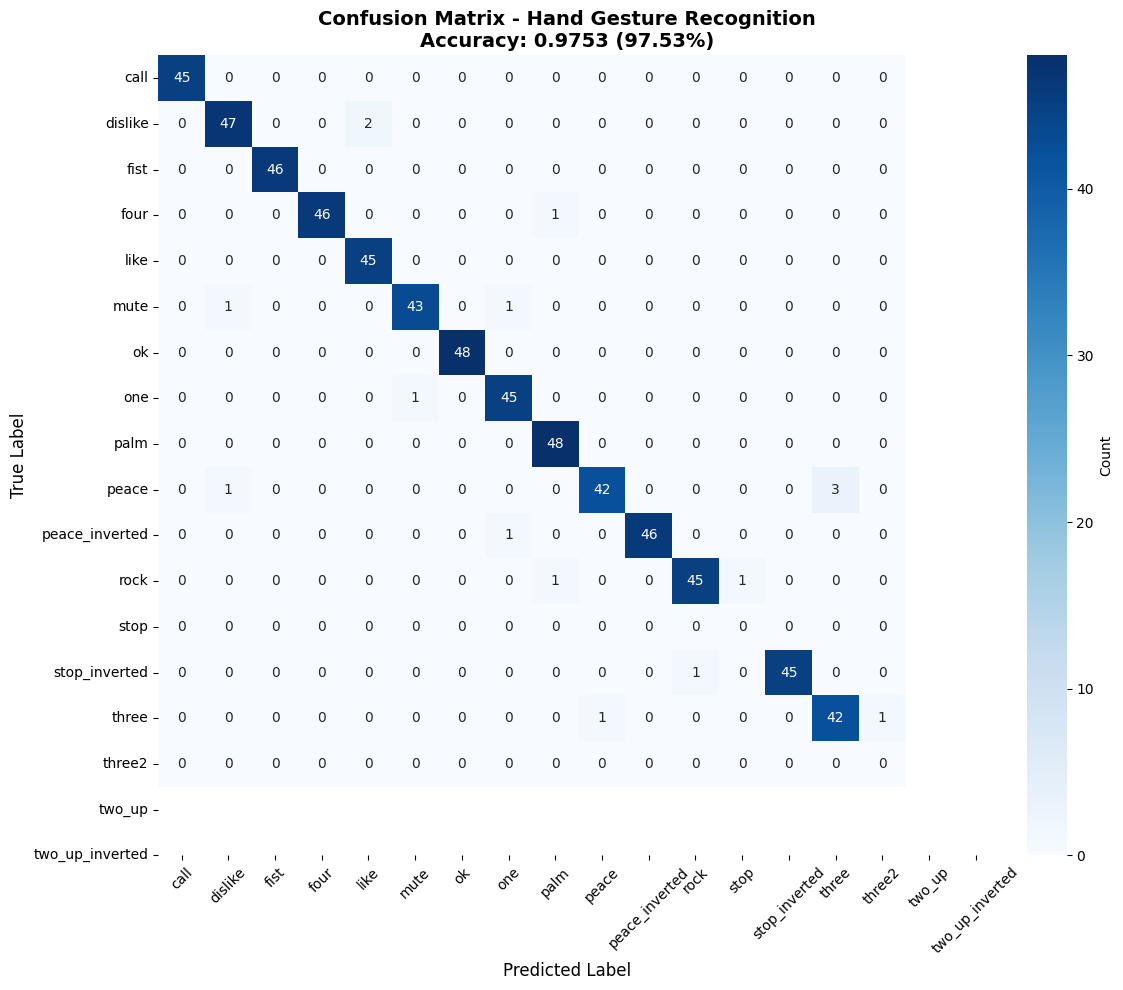

C:\Users\nhail\AppData\Local\Temp\ipykernel_24392\1221467627.py:28: RuntimeWarning: invalid value encountered in divide
  cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


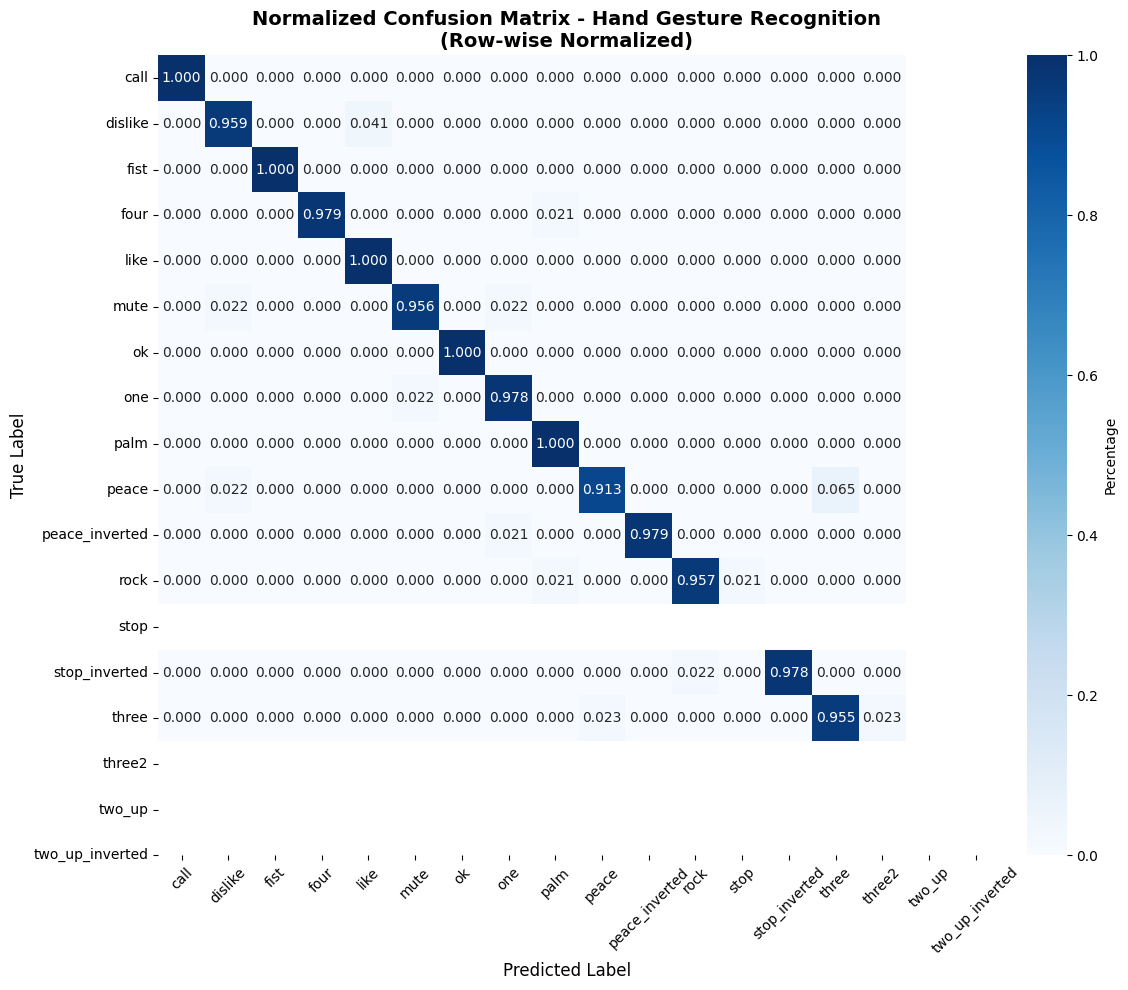

In [9]:
# Confusion Matrix Visualization
cm = confusion_matrix(y_test_encoded, y_pred)

print("🔢 Confusion Matrix (Raw Counts):")
print(cm)

# Create a more visual confusion matrix
plt.figure(figsize=(12, 10))
sns.heatmap(
    cm, 
    annot=True, 
    fmt='d', 
    cmap='Blues',
    xticklabels=label_encoder.classes_,
    yticklabels=label_encoder.classes_,
    cbar_kws={'label': 'Count'}
)
plt.title(f'Confusion Matrix - Hand Gesture Recognition\nAccuracy: {accuracy:.4f} ({accuracy*100:.2f}%)', 
          fontsize=14, fontweight='bold')
plt.xlabel('Predicted Label', fontsize=12)
plt.ylabel('True Label', fontsize=12)
plt.xticks(rotation=45)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

# Normalized confusion matrix (percentages)
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

plt.figure(figsize=(12, 10))
sns.heatmap(
    cm_normalized, 
    annot=True, 
    fmt='.3f', 
    cmap='Blues',
    xticklabels=label_encoder.classes_,
    yticklabels=label_encoder.classes_,
    cbar_kws={'label': 'Percentage'}
)
plt.title(f'Normalized Confusion Matrix - Hand Gesture Recognition\n(Row-wise Normalized)', 
          fontsize=14, fontweight='bold')
plt.xlabel('Predicted Label', fontsize=12)
plt.ylabel('True Label', fontsize=12)
plt.xticks(rotation=45)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

🎯 Per-Class Accuracy Analysis:
call           : 1.0000 (100.00%) -  45 samples
dislike        : 0.9592 (95.92%) -  49 samples
fist           : 1.0000 (100.00%) -  46 samples
four           : 0.9787 (97.87%) -  47 samples
like           : 1.0000 (100.00%) -  45 samples
mute           : 0.9556 (95.56%) -  45 samples
ok             : 1.0000 (100.00%) -  48 samples
one            : 0.9783 (97.83%) -  46 samples
palm           : 1.0000 (100.00%) -  48 samples
peace          : 0.9130 (91.30%) -  46 samples
peace_inverted : No samples
rock           : 0.9787 (97.87%) -  47 samples
stop           : 0.9574 (95.74%) -  47 samples
stop_inverted  : No samples
three          : 0.9783 (97.83%) -  46 samples
three2         : No samples
two_up         : 0.9545 (95.45%) -  44 samples
two_up_inverted: No samples


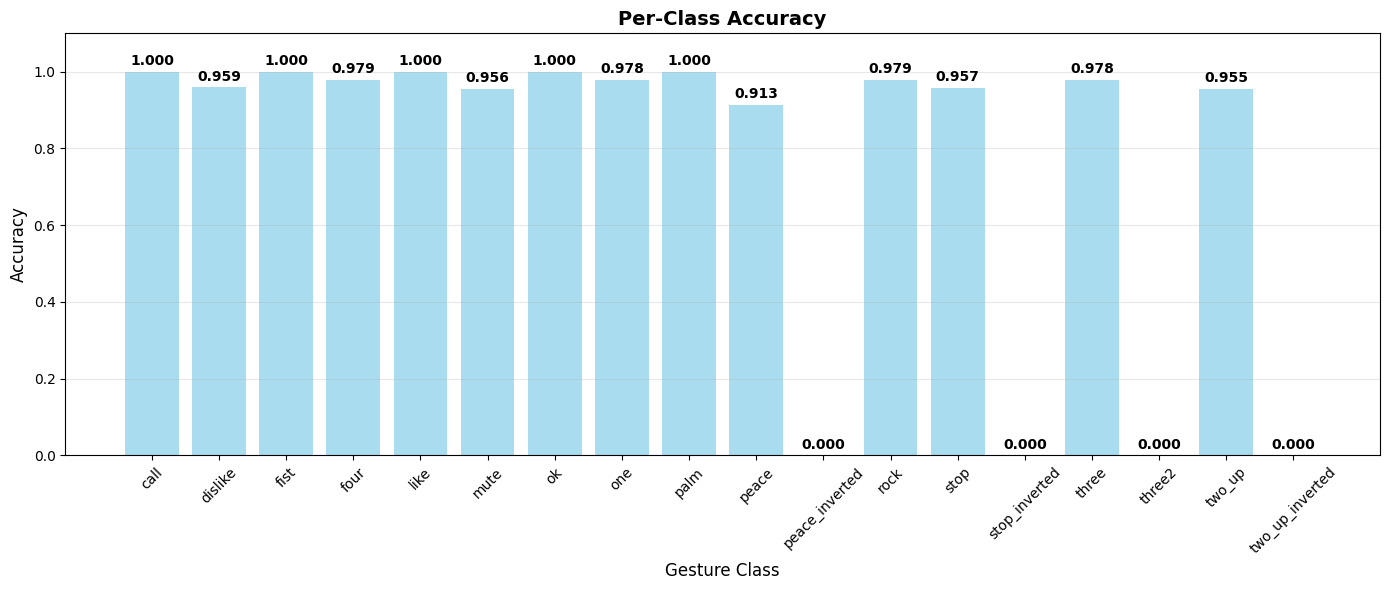


📊 Summary Statistics:
Average per-class accuracy: 0.7585
Best performing class: call (1.0000)
Worst performing class: peace_inverted (0.0000)
Standard deviation: 0.4060


In [10]:
# Per-Class Accuracy Analysis
print("🎯 Per-Class Accuracy Analysis:")
print("="*40)

per_class_accuracy = []
gesture_names = label_encoder.classes_

for i, gesture in enumerate(gesture_names):
    # Calculate accuracy for this class
    class_mask = (y_test_encoded == i)
    if np.sum(class_mask) > 0:
        class_accuracy = np.sum((y_test_encoded == i) & (y_pred == i)) / np.sum(class_mask)
        per_class_accuracy.append(class_accuracy)
        print(f"{gesture:15}: {class_accuracy:.4f} ({class_accuracy*100:.2f}%) - {np.sum(class_mask):3d} samples")
    else:
        per_class_accuracy.append(0.0)
        print(f"{gesture:15}: No samples")

# Visualize per-class accuracy
plt.figure(figsize=(14, 6))
bars = plt.bar(gesture_names, per_class_accuracy, color='skyblue', alpha=0.7)
plt.title('Per-Class Accuracy', fontsize=14, fontweight='bold')
plt.xlabel('Gesture Class', fontsize=12)
plt.ylabel('Accuracy', fontsize=12)
plt.xticks(rotation=45)
plt.ylim(0, 1.1)

# Add value labels on bars
for bar, acc in zip(bars, per_class_accuracy):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01, 
             f'{acc:.3f}', ha='center', va='bottom', fontweight='bold')

plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()

# Summary statistics
print(f"\n📊 Summary Statistics:")
print(f"Average per-class accuracy: {np.mean(per_class_accuracy):.4f}")
print(f"Best performing class: {gesture_names[np.argmax(per_class_accuracy)]} ({max(per_class_accuracy):.4f})")
print(f"Worst performing class: {gesture_names[np.argmin(per_class_accuracy)]} ({min(per_class_accuracy):.4f})")
print(f"Standard deviation: {np.std(per_class_accuracy):.4f}")

In [11]:
# Final Summary and Configuration Recap
print("🎉 EVALUATION COMPLETED!")
print("="*50)

print(f"📝 Configuration Used:")
print(f"   • Max images per folder: {max_img}")
print(f"   • Test folder: {test_folder}")
print(f"   • Model type: {'SVM' if 'SVM' in models else list(models.keys())[0]}")
print(f"   • Features extracted: {len(feature_names)}")

print(f"\n📊 Processing Summary:")
print(f"   • Total images processed: {processed_count}")
print(f"   • Failed to process: {failed_count}")
print(f"   • Success rate: {processed_count/(processed_count + failed_count)*100:.2f}%")

print(f"\n🎯 Model Performance:")
print(f"   • Overall Accuracy: {accuracy:.4f} ({accuracy*100:.2f}%)")
print(f"   • Number of classes: {len(label_encoder.classes_)}")
print(f"   • Test samples: {len(y_test)}")

print(f"\n🏆 Best/Worst Performing Classes:")
best_idx = np.argmax(per_class_accuracy)
worst_idx = np.argmin(per_class_accuracy)
print(f"   • Best: {gesture_names[best_idx]} ({per_class_accuracy[best_idx]:.4f})")
print(f"   • Worst: {gesture_names[worst_idx]} ({per_class_accuracy[worst_idx]:.4f})")

print(f"\n💡 Tip: You can adjust the 'max_img' parameter in the first cell to test with more or fewer images per gesture folder.")

# Close MediaPipe
detector.close()
print("\n✅ MediaPipe detector closed successfully.")

🎉 EVALUATION COMPLETED!
📝 Configuration Used:
   • Max images per folder: 50
   • Test folder: d:/HAND_GESTURE/Data/hagrid_test
   • Model type: SVM
   • Features extracted: 69

📊 Processing Summary:
   • Total images processed: 649
   • Failed to process: 51
   • Success rate: 92.71%

🎯 Model Performance:
   • Overall Accuracy: 0.9753 (97.53%)
   • Number of classes: 18
   • Test samples: 649

🏆 Best/Worst Performing Classes:
   • Best: call (1.0000)
   • Worst: peace_inverted (0.0000)

💡 Tip: You can adjust the 'max_img' parameter in the first cell to test with more or fewer images per gesture folder.

✅ MediaPipe detector closed successfully.
